# 📚 Instalasi & Import Library
Instalasi prophet dilakukan untuk forecasting data time series. Selanjutnya, import library standar Python untuk manipulasi data dan visualisasi. Prophet digunakan untuk membuat model prediksi deret waktu.

In [113]:
# Instalasi library Prophet untuk forecasting
!pip install prophet

In [114]:
# Import library dasar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prophet untuk forecasting time series
from prophet import Prophet

# 📚 Dataset 1
Dataset yang digunakan berasal dari Kaggle dengan judul "Personal Budget Transactions Dataset". Dataset ini berisi catatan transaksi pengeluaran pribadi seperti makanan, transportasi, kesehatan, lifestyle, dan lainnya.

📌 Sumber dataset: [Personal Budget Transactions Dataset](https://www.kaggle.com/datasets/ismetsemedov/personal-budget-transactions-dataset/data)

Dataset digunakan untuk keperluan forecasting pengeluaran berdasarkan kategori transaksi.

## Load Dataset
Pada tahap ini, dilakukan proses pengunduhan dan pembacaan dataset dari sumber eksternal. Dataset ini berisi catatan transaksi pribadi yang akan digunakan untuk proses analisis dan forecasting.

In [115]:
# Mengambil dataset dari Google Drive
file_id = '1mKBH1ZF6Q003wMSTOE_KdwR2UzGr7vH0'
url = f'https://drive.google.com/uc?id={file_id}'

# Membaca dataset CSV
df = pd.read_csv(url, on_bad_lines='skip')

# Melihat 5 data teratas
df.head()

,date,category,amount
0,2022-07-06 05:57:10 +0000,Restuarant,5.50
1,2022-07-06 05:57:27 +0000,Market,2.00
2,2022-07-06 05:58:12 +0000,Coffe,30.10
3,2022-07-06 05:58:25 +0000,Market,17.33
4,2022-07-06 05:59:00 +0000,Restuarant,5.50


## 🔍 Eksplorasi Awal Dataset
Eksplorasi awal dilakukan untuk memahami struktur data, melihat tipe data, dan mendeteksi apakah terdapat nilai kosong (NaN) maupun data duplikat yang perlu dibersihkan.



In [116]:
# Informasi tipe data, jumlah kolom, dan jumlah data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597 entries, 0 to 4596
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      4597 non-null   object 
 1   category  4597 non-null   object 
 2   amount    4597 non-null   float64
dtypes: float64(1), object(2)
memory usage: 107.9+ KB


In [117]:
# Menampilkan jumlah nilai kosong per kolom
df.isna().sum()

,0
date,0
category,0
amount,0


In [118]:
# Menampilkan jumlah data duplikat
df.duplicated().sum()

np.int64(0)

### 🕓 Konversi Format Tanggal
Agar analisis time series dapat berjalan dengan baik, kolom date harus dikonversi ke format datetime, menghapus timezone, dan dinormalisasi menjadi format tanggal standar (tanpa jam).

In [119]:
# Konversi kolom 'date' ke datetime
df['date'] = pd.to_datetime(df['date'])

# Menghapus informasi timezone
df['date'] = df['date'].dt.tz_localize(None)

# Normalisasi tanggal (menghilangkan jam)
df['date'] = df['date'].dt.normalize()

# Konfirmasi tipe data hasil konversi
print(df.dtypes)

date        datetime64[ns]
category            object
amount             float64
dtype: object


## 📊 Visualisasi Distribusi Kategori
Visualisasi digunakan untuk melihat seberapa banyak masing-masing kategori transaksi secara grafis, agar pola kategori mudah dipahami sebelum dilakukan transformasi lebih lanjut.

category
Business lunch        300
Clothing               49
Coffe                1248
Communal               35
Events                 51
Film/enjoyment          4
Fuel                    8
Health                 50
Learning               99
Market               1142
Motel                   1
Other                  98
Phone                 141
Rent Car                2
Restuarant            538
Sport                  32
Taxi                  237
Tech                   12
Transport             518
Travel                  8
business_expenses      11
joy                    13
Name: count, dtype: int64


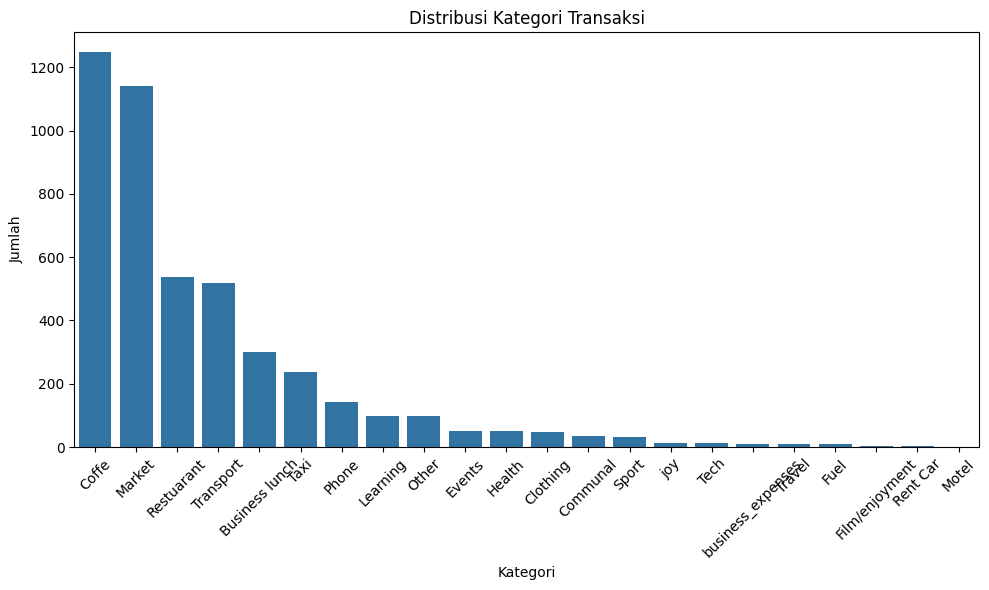

In [120]:
# Melihat distribusi kategori transaksi sebelum mapping
print(df['category'].value_counts().sort_index())

# Visualisasi distribusi kategori transaksi
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribusi Kategori Transaksi')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

## 🗂️ Pengelompokan Ulang Kategori
Karena terdapat banyak kategori yang serupa, dilakukan proses pengelompokan ulang agar lebih ringkas dan mudah dianalisis.

In [121]:
# Mapping ulang kategori transaksi
category_mapping = {
    # Food & Beverages
    'Coffe': 'Food & Beverages',
    'Restuarant': 'Food & Beverages',
    'Business lunch': 'Food & Beverages',

    # Transportation
    'Taxi': 'Transportation',
    'Transport': 'Transportation',
    'Rent Car': 'Transportation',
    'Fuel': 'Transportation',

    # Health
    'Health': 'Health',

    # Lifestyle
    'Clothing': 'Lifestyle',
    'Sport': 'Lifestyle',
    'Events': 'Lifestyle',
    'Film/enjoyment': 'Lifestyle',
    'joy': 'Lifestyle',
    'Learning': 'Lifestyle',
    'Tech': 'Lifestyle',
    'Phone': 'Lifestyle',
    'Travel': 'Lifestyle',
    'Market': 'Lifestyle',
    'Motel': 'Lifestyle',

    # Others
    'Other': 'Others',
    'Communal': 'Others',
    'business_expenses': 'Others'
}

# Mapping kategori transaksi sesuai kelompok baru
df['category'] = df['category'].map(category_mapping).fillna('Others')

# Rename kolom menjadi 'kategori'
df.rename(columns={'category': 'kategori'}, inplace=True)

## 💱 Konversi Mata Uang ke IDR
Dataset ini menggunakan mata uang USD. Untuk relevansi dengan kondisi lokal Indonesia, nilai transaksi dikonversikan ke IDR menggunakan kurs tetap sebesar 1 USD = 16.245 IDR.



In [122]:
# Kurs konversi USD ke IDR
kurs = 16245

# Mengkonversi nilai transaksi ke Rupiah
df['amount'] = df['amount'].astype(float) * kurs

## ✅ Final Check Dataset
Tahapan terakhir memastikan bahwa dataset sudah bersih, siap untuk tahap analisis lanjutan atau model forecasting.

In [123]:
# Informasi final dataset setelah pre-processing
df.info()

# Melihat 5 data teratas setelah bersih
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597 entries, 0 to 4596
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      4597 non-null   datetime64[ns]
 1   kategori  4597 non-null   object        
 2   amount    4597 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 107.9+ KB


,date,kategori,amount
0,2022-07-06,Food & Beverages,89347.50
1,2022-07-06,Lifestyle,32490.00
2,2022-07-06,Food & Beverages,488974.50
3,2022-07-06,Lifestyle,281525.85
4,2022-07-06,Food & Beverages,89347.50


# 📂 Dataset 2
Dataset kedua digunakan untuk analisis transaksi pribadi. Sumber dataset ini tidak diketahui secara pasti. Dataset diunggah melalui Google Drive dan dibaca langsung menggunakan `pandas`. Pada tahap ini dilakukan proses pembersihan data agar siap digunakan untuk analisis lebih lanjut.

## 🚀 Load Dataset
Pada tahap ini dilakukan proses pembacaan dataset dari file CSV yang disimpan di Google Drive. Pemisah kolom dataset ini menggunakan tanda titik koma (;).


In [124]:
# ID file dari Google Drive
file_id = '1DzvN8okQyZmqv0ezBZjC7tbrMItbieJV'
url = f'https://drive.google.com/uc?id={file_id}'

# Membaca dataset dan mengabaikan baris yang bermasalah
df2 = pd.read_csv(url, sep=';', on_bad_lines='skip')

# Menampilkan 5 data teratas
df2.head()

,Date,Description,Debit,Credit,Sub-category,Category,Category Type,Month Number,Weekday,Amount
0,1/4/21,Data With Decision,NaN,5000.0,Data with Decision,Salary,Income,1,Mon,5000
1,1/4/21,Drink,5,NaN,Coffee,Dining Out,Expense,1,Mon,-5
2,1/5/21,Estate Mangement,900,NaN,Rent,Living Expenses,Expense,1,Tue,-900
3,1/5/21,Financail upgrade,150,NaN,Cash loan,Transport,Expense,1,Tue,-150
4,1/5/21,Drink,5,NaN,Coffee,Dining Out,Expense,1,Tue,-5


## 🔎 Eksplorasi Awal Dataset
Eksplorasi dilakukan untuk melihat tipe data, jumlah missing values, dan jumlah data duplikat.

In [125]:
# Melihat informasi umum dataset
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           486 non-null    object 
 1   Description    486 non-null    object 
 2   Debit          465 non-null    object 
 3   Credit         21 non-null     float64
 4   Sub-category   486 non-null    object 
 5   Category       486 non-null    object 
 6   Category Type  486 non-null    object 
 7   Month Number   486 non-null    int64  
 8   Weekday        486 non-null    object 
 9   Amount         486 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 38.1+ KB


In [126]:
# Mengecek jumlah nilai kosong
df2.isna().sum()

,0
Date,0
Description,0
Debit,21
Credit,465
Sub-category,0
Category,0
Category Type,0
Month Number,0
Weekday,0
Amount,0


In [127]:
# Mengecek jumlah data duplikat
df2.duplicated().sum()

np.int64(4)

## 🧹 Preprocessing Data
Tahap ini berfokus pada pembersihan data, termasuk menghapus duplikasi, memilih kolom yang relevan, dan normalisasi format tanggal.


In [128]:
# Menghapus data duplikat
df2 = df2.drop_duplicates()

In [129]:
# Memilih kolom yang relevan
df2 = df2[['Date', 'Category', 'Amount']].copy()

In [130]:
# Mengubah nama kolom agar konsisten
df2.rename(columns={
    'Date': 'date',
    'Category': 'kategori',
    'Amount': 'amount'
}, inplace=True)

In [131]:
# Mengubah kolom 'date' menjadi tipe datetime tanpa timezone
df2['date'] = pd.to_datetime(df2['date'])
df2['date'] = df2['date'].dt.tz_localize(None)
df2['date'] = df2['date'].dt.normalize()

# Mengecek kembali tipe data
print(df2.dtypes)

date        datetime64[ns]
kategori            object
amount              object
dtype: object


<ipython-input-131-4191397921>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['date'] = pd.to_datetime(df2['date'])


## 💰 Konversi Nilai Amount
Dataset memiliki format angka yang masih berbentuk string dan terdapat tanda koma. Langkah ini mengubahnya menjadi float agar dapat diproses lebih lanjut.

In [132]:
# Mengubah format angka dari string ke float
df2['amount'] = df2['amount'].replace(',', '', regex=True).astype(float)

# Mengecek kembali tipe data
print(df2.dtypes)

date        datetime64[ns]
kategori            object
amount             float64
dtype: object


## 📊 Visualisasi Distribusi Kategori
Menampilkan visualisasi untuk melihat distribusi jumlah transaksi berdasarkan kategori awal.

kategori
Charity             10
Dining Out         259
Discretionary       70
Living Expenses     70
Medical              3
Passive             11
Salary              10
Transport           49
Name: count, dtype: int64


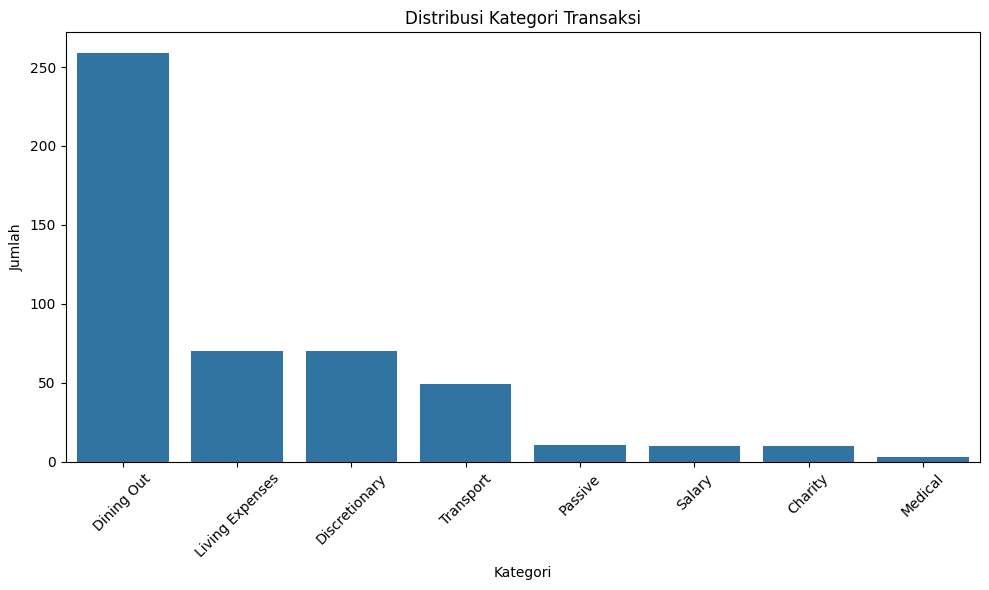

In [133]:
# Melihat distribusi kategori transaksi sebelum mapping
print(df2['kategori'].value_counts().sort_index())

# Visualisasi distribusi kategori transaksi
plt.figure(figsize=(10,6))
sns.countplot(data=df2, x='kategori', order=df2['kategori'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribusi Kategori Transaksi')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

## 🗂️ Mapping Kategori
Kategori awal transaksi masih kurang jelas, sehingga dilakukan pemetaan ulang agar lebih terstruktur sesuai dengan klasifikasi yang telah ditentukan.

In [134]:
# Mapping ulang kategori transaksi
mapping_kategori = {
    'Charity': 'Others',
    'Dining Out': 'Food & Beverages',
    'Discretionary': 'Lifestyle',
    'Living Expenses': 'Housing',
    'Medical': 'Health',
    'Passive': 'Income',
    'Salary': 'Income',
    'Transport': 'Transportation'
}

df2['kategori'] = df2['kategori'].map(mapping_kategori).fillna('Others')

## 💱 Konversi Mata Uang
Seluruh transaksi masih dalam USD, sehingga dikonversi ke IDR dengan kurs tetap sebesar 16.245.

In [135]:
# Mengubah nilai amount menjadi absolut (positif)
df2['amount'] = df2['amount'].abs()

# Kurs 1 USD ke IDR
kurs2 = 16245

# Mengonversi nilai amount ke IDR
df2['amount'] = df2['amount'].astype(float) * kurs2

## ✅ Finalisasi Dataset
Pemeriksaan akhir dataset setelah proses pembersihan dan transformasi selesai.

In [136]:
# Menampilkan info dataset terbaru
df2.info()

# Menampilkan data awal setelah transformasi
df2.head()

<class 'pandas.core.frame.DataFrame'>
Index: 482 entries, 0 to 485
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      482 non-null    datetime64[ns]
 1   kategori  482 non-null    object        
 2   amount    482 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 15.1+ KB


,date,kategori,amount
0,2021-01-04,Income,81225000.0
1,2021-01-04,Food & Beverages,81225.0
2,2021-01-05,Housing,14620500.0
3,2021-01-05,Transportation,2436750.0
4,2021-01-05,Food & Beverages,81225.0


# 📂 Dataset 3
Dataset ketiga berasal dari Kaggle dengan judul Daily Transactions Dataset.

Link Sumber : [Daily Transactions Dataset](https://www.kaggle.com/datasets/prasad22/daily-transactions-dataset)

Dataset ini berisi data transaksi harian yang mencakup berbagai kategori pengeluaran dan pemasukan. Dataset diunggah melalui Google Drive dan dibaca menggunakan `pandas`.

## 🚀 Load Dataset
Tahap ini digunakan untuk membaca dataset dari file CSV yang telah diunggah ke Google Drive. Dataset memiliki banyak kategori transaksi yang akan dipetakan ulang nantinya.

In [137]:
# ID file dari Google Drive
file_id = '1z4a3UftyxlfqTrlqPOS2avMDO80G4tlH'
url = f'https://drive.google.com/uc?id={file_id}'

# Membaca dataset dan mengabaikan baris bermasalah
df3 = pd.read_csv(url, on_bad_lines='skip')

# Menampilkan 5 data teratas
df3.head()

,Date,Mode,Category,Subcategory,Note,Amount,Income/Expense,Currency
0,20/09/2018 12:04:08,Cash,Transportation,Train,2 Place 5 to Place 0,30.0,Expense,INR
1,20/09/2018 12:03:15,Cash,Food,snacks,Idli medu Vada mix 2 plates,60.0,Expense,INR
2,19/09/2018,Saving Bank account 1,subscription,Netflix,1 month subscription,199.0,Expense,INR
3,17/09/2018 23:41:17,Saving Bank account 1,subscription,Mobile Service Provider,Data booster pack,19.0,Expense,INR
4,16/09/2018 17:15:08,Cash,Festivals,Ganesh Pujan,Ganesh idol,251.0,Expense,INR


## 🔎 Eksplorasi Awal Dataset
Eksplorasi awal dilakukan untuk mengetahui struktur dataset, termasuk tipe data, nilai kosong, dan duplikasi.


In [138]:
# Melihat informasi umum dataset
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2461 entries, 0 to 2460
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2461 non-null   object 
 1   Mode            2461 non-null   object 
 2   Category        2461 non-null   object 
 3   Subcategory     1826 non-null   object 
 4   Note            1940 non-null   object 
 5   Amount          2461 non-null   float64
 6   Income/Expense  2461 non-null   object 
 7   Currency        2461 non-null   object 
dtypes: float64(1), object(7)
memory usage: 153.9+ KB


In [139]:
# Mengecek jumlah nilai kosong
df3.isna().sum()

,0
Date,0
Mode,0
Category,0
Subcategory,635
Note,521
Amount,0
Income/Expense,0
Currency,0


In [140]:
# Mengecek jumlah data duplikat
df3.duplicated().sum()

np.int64(9)

## 🧹 Preprocessing Data
Pembersihan data dilakukan dengan menghapus duplikat, memilih kolom yang relevan, mengganti nama kolom agar lebih konsisten, serta memperbaiki format tanggal.


In [141]:
# Menghapus data duplikat
df3 = df3.drop_duplicates()

In [142]:
# Memilih kolom relevan
df3 = df3[['Date', 'Category', 'Amount']].copy()

In [143]:
# Mengganti nama kolom
df3.rename(columns={
    'Date': 'date',
    'Category': 'kategori',
    'Amount': 'amount'
}, inplace=True)

In [144]:
# Mengubah kolom 'date' menjadi tipe datetime (dayfirst=True karena format India)
df3['date'] = pd.to_datetime(df3['date'], dayfirst=True, errors='coerce').dt.normalize()

# Mengecek tipe data
print(df3.dtypes)

date        datetime64[ns]
kategori            object
amount             float64
dtype: object


## 📅 Penyesuaian Tanggal Transaksi
Beberapa data memiliki tanggal yang tidak valid atau tidak sesuai. Oleh karena itu dilakukan rekonstruksi tanggal untuk memastikan terdapat 2 transaksi per hari dimulai dari tanggal 21 September 2018.

In [145]:
# Contoh jumlah data (jumlah transaksi)
n = len(df3)

# Tanggal mulai
start_date = pd.Timestamp('2018-09-21')

# Hitung berapa hari perlu dibuat supaya ada 2 transaksi/hari menutupi n data
days_needed = int(np.ceil(n / 2))

# Generate daftar tanggal dengan frekuensi harian sebanyak days_needed
dates = pd.date_range(start=start_date, periods=days_needed, freq='D')

# Buat list tanggal, tiap tanggal muncul 2 kali (2 transaksi per hari)
dates_repeated = np.repeat(dates, 2)

# Jika jumlah dates lebih banyak dari jumlah data, sesuaikan agar panjang sama
dates_final = dates_repeated[:n]

# Assign ke kolom 'date'
df3['date'] = dates_final

## 📊 Visualisasi Distribusi Kategori
Distribusi kategori transaksi awal divisualisasikan untuk memahami komposisi data sebelum dilakukan pemetaan ulang kategori.

kategori
Amazon pay cashback            2
Apparel                       47
Beauty                        22
Bonus                          6
Cook                           4
Culture                       11
Dividend earned on Shares     12
Documents                      2
Education                     18
Equity Mutual Fund A          14
Equity Mutual Fund B           1
Equity Mutual Fund C           6
Equity Mutual Fund D           1
Equity Mutual Fund E          22
Equity Mutual Fund F          13
Family                        71
Festivals                     16
Fixed Deposit                  2
Food                         906
Gift                          30
Gpay Reward                   21
Grooming                       4
Health                        94
Household                    176
Interest                      12
Investment                   101
Life Insurance                 7
Maturity amount                7
Money transfer                43
Other                        126
P

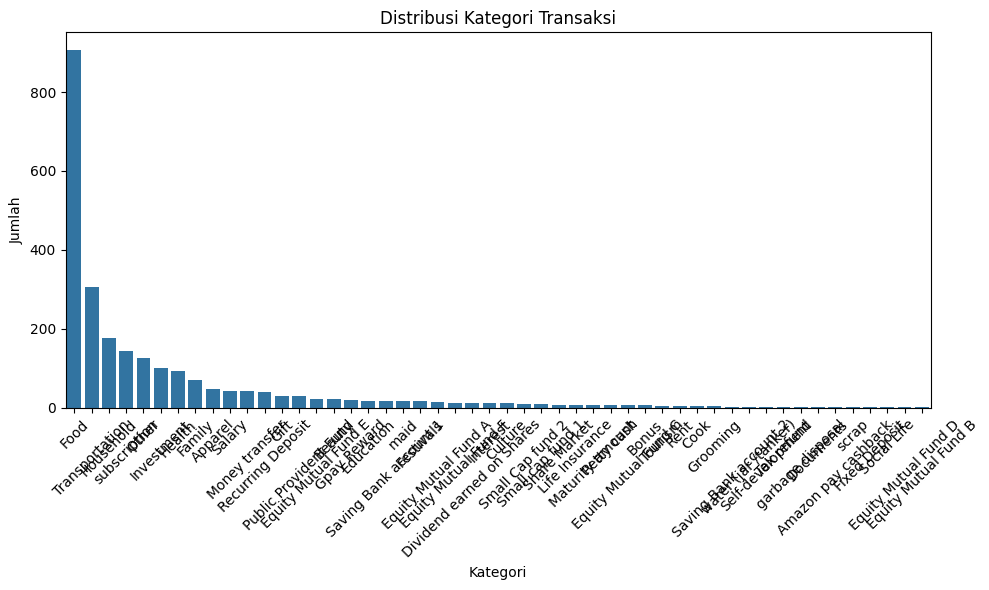

In [146]:
# Melihat distribusi kategori transaksi awal
print(df3['kategori'].value_counts().sort_index())

# Visualisasi distribusi kategori
plt.figure(figsize=(10,6))
sns.countplot(data=df3, x='kategori', order=df3['kategori'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribusi Kategori Transaksi')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

## 🗂️ Mapping Kategori
Kategori transaksi masih sangat beragam dan kurang konsisten, sehingga dilakukan pemetaan ulang menjadi beberapa kategori utama sesuai dengan struktur yang telah digunakan di dataset sebelumnya.

In [147]:
# Mapping ulang kategori transaksi
mapping_dict = {
    'Amazon pay cashback': 'Income',
    'Apparel': 'Lifestyle',
    'Beauty': 'Lifestyle',
    'Bonus': 'Income',
    'Cook': 'Food & Beverages',
    'Culture': 'Lifestyle',
    'Dividend earned on Shares': 'Income',
    'Documents': 'Others',
    'Education': 'Lifestyle',
    'Equity Mutual Fund A': 'Others',
    'Equity Mutual Fund B': 'Others',
    'Equity Mutual Fund C': 'Others',
    'Equity Mutual Fund D': 'Others',
    'Equity Mutual Fund E': 'Others',
    'Equity Mutual Fund F': 'Others',
    'Family': 'Lifestyle',
    'Festivals': 'Lifestyle',
    'Fixed Deposit': 'Others',
    'Food': 'Food & Beverages',
    'Gift': 'Others',
    'Gpay Reward': 'Income',
    'Grooming': 'Lifestyle',
    'Health': 'Health',
    'Household': 'Housing',
    'Interest': 'Income',
    'Investment': 'Others',
    'Life Insurance': 'Health',
    'Maturity amount': 'Income',
    'Money transfer': 'Others',
    'Other': 'Others',
    'Petty cash': 'Income',
    'Public Provident Fund': 'Others',
    'Recurring Deposit': 'Others',
    'Rent': 'Housing',
    'Salary': 'Income',
    'Saving Bank account 1': 'Others',
    'Saving Bank account 2': 'Others',
    'Self-development': 'Lifestyle',
    'Share Market': 'Others',
    'Small Cap fund 2': 'Others',
    'Small cap fund 1': 'Others',
    'Social Life': 'Lifestyle',
    'Tax refund': 'Income',
    'Tourism': 'Lifestyle',
    'Transportation': 'Transportation',
    'garbage disposal': 'Housing',
    'maid': 'Housing',
    'scrap': 'Income',
    'subscription': 'Lifestyle',
    'water (jar /tanker)': 'Housing'
}

df3['kategori'] = df3['kategori'].map(mapping_dict).fillna('Others')

## 💱 Konversi Mata Uang
Seluruh transaksi dalam dataset ini masih dalam mata uang INR. Oleh karena itu dikonversi ke IDR menggunakan kurs tetap 1 INR = 191 IDR.


In [148]:
# Jika 1 INR = 191 IDR
kurs3 = 191

# Pastikan data awal amount masih dalam INR
df3['amount'] = df3['amount'].astype(float) * kurs3

## ✅ Finalisasi Dataset
Pemeriksaan akhir dataset untuk memastikan hasil transformasi telah sesuai dan siap digunakan untuk proses analisis lebih lanjut.

In [149]:
# Menampilkan informasi dataset terkini
df3.info()

# Menampilkan data awal setelah transformasi
df3.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2452 entries, 0 to 2460
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2452 non-null   datetime64[ns]
 1   kategori  2452 non-null   object        
 2   amount    2452 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 76.6+ KB


,date,kategori,amount
0,2018-09-21,Transportation,5730.0
1,2018-09-21,Food & Beverages,11460.0
2,2018-09-22,Lifestyle,38009.0
3,2018-09-22,Lifestyle,3629.0
4,2018-09-23,Lifestyle,47941.0


# 📌 Penggabungan Dataset
Setelah proses pembersihan dan transformasi masing-masing dataset (dataset 1, dataset 2, dan dataset 3) selesai, langkah selanjutnya adalah menggabungkan semua data transaksi ke dalam satu DataFrame utama untuk analisis agregat yang lebih komprehensif. Proses ini juga mencakup klasifikasi tipe transaksi (Pemasukan vs Pengeluaran), perhitungan total, dan pengecekan ulang terhadap data duplikat maupun data kosong.

## 🗂️ Menggabungkan Tiga Dataset Menjadi Satu DataFrame
Langkah awal setelah seluruh dataset (1, 2, dan 3) selesai dibersihkan adalah menggabungkannya ke dalam satu DataFrame yang akan menjadi dasar analisis selanjutnya. Penggabungan ini dilakukan menggunakan fungsi `pd.concat()` dengan parameter `ignore_index=True` agar index direset secara otomatis.

In [150]:
# Menggabungkan ketiga dataset menjadi satu DataFrame
df_all = pd.concat([df, df2, df3], ignore_index=True)

# Menampilkan hasil gabungan
df_all

,date,kategori,amount
0,2022-07-06,Food & Beverages,89347.50
1,2022-07-06,Lifestyle,32490.00
2,2022-07-06,Food & Beverages,488974.50
3,2022-07-06,Lifestyle,281525.85
4,2022-07-06,Food & Beverages,89347.50
...,...,...,...
7526,2022-01-26,Transportation,3820.00
7527,2022-01-27,Transportation,3820.00
7528,2022-01-27,Transportation,5730.00
7529,2022-01-28,Food & Beverages,1910.00


## 🔎 Menampilkan Daftar Kategori Transaksi
Setelah data digabung, langkah berikutnya adalah melihat kategori-kategori transaksi yang tersedia. Ini bertujuan untuk memastikan bahwa label pada kolom `kategori` sudah konsisten.

In [151]:
# Melihat kategori unik dari transaksi

print(df_all['kategori'].unique())

['Food & Beverages' 'Lifestyle' 'Transportation' 'Others' 'Health'
 'Income' 'Housing']


## 🏷️ Menambahkan Kolom Tipe (Income / Expense)
Untuk memudahkan analisis total pemasukan dan pengeluaran, dibuat kolom baru bernama tipe. Kolom ini diisi dengan nilai "Income" apabila kategori bernilai "Income", dan "Expense" untuk kategori lainnya.

In [152]:
# Menambahkan kolom 'tipe' untuk membedakan pemasukan dan pengeluaran
df_all['tipe'] = df_all['kategori'].apply(lambda x: 'Income' if x == 'Income' else 'Expense')

# Menampilkan DataFrame setelah penambahan kolom
df_all

,date,kategori,amount,tipe
0,2022-07-06,Food & Beverages,89347.50,Expense
1,2022-07-06,Lifestyle,32490.00,Expense
2,2022-07-06,Food & Beverages,488974.50,Expense
3,2022-07-06,Lifestyle,281525.85,Expense
4,2022-07-06,Food & Beverages,89347.50,Expense
...,...,...,...,...
7526,2022-01-26,Transportation,3820.00,Expense
7527,2022-01-27,Transportation,3820.00,Expense
7528,2022-01-27,Transportation,5730.00,Expense
7529,2022-01-28,Food & Beverages,1910.00,Expense


## 📂 Menampilkan Transaksi Berdasarkan Tipe
Data transaksi kemudian ditampilkan secara terpisah berdasarkan kolom tipe. Ini bertujuan untuk memastikan proses klasifikasi berjalan sesuai.

In [153]:
# Menampilkan transaksi bertipe Income
print(df_all[df_all['tipe'] == 'Income'])

           date kategori      amount    tipe
4597 2021-01-04   Income  81225000.0  Income
4619 2021-01-18   Income  73102500.0  Income
4622 2021-01-19   Income  73102500.0  Income
4644 2021-02-01   Income  81225000.0  Income
4666 2021-02-15   Income  12996000.0  Income
...         ...      ...         ...     ...
7257 2021-09-14   Income   9141069.0  Income
7270 2021-09-20   Income   9141069.0  Income
7302 2021-10-06   Income   9417446.0  Income
7326 2021-10-18   Income  13523946.0  Income
7387 2021-11-18   Income   9512946.0  Income

[134 rows x 4 columns]


In [154]:
# Menampilkan transaksi bertipe Expense
print(df_all[df_all['tipe'] == 'Expense'])

           date          kategori     amount     tipe
0    2022-07-06  Food & Beverages   89347.50  Expense
1    2022-07-06         Lifestyle   32490.00  Expense
2    2022-07-06  Food & Beverages  488974.50  Expense
3    2022-07-06         Lifestyle  281525.85  Expense
4    2022-07-06  Food & Beverages   89347.50  Expense
...         ...               ...        ...      ...
7526 2022-01-26    Transportation    3820.00  Expense
7527 2022-01-27    Transportation    3820.00  Expense
7528 2022-01-27    Transportation    5730.00  Expense
7529 2022-01-28  Food & Beverages    1910.00  Expense
7530 2022-01-28    Transportation    1910.00  Expense

[7397 rows x 4 columns]


## 💰 Menghitung Total Pemasukan dan Pengeluaran
Selanjutnya dilakukan proses kalkulasi jumlah total dari setiap tipe transaksi. Fungsi `sum()` digunakan untuk menjumlahkan nominal pada kolom `amount`.

In [155]:
# Menghitung total pemasukan
total_pemasukan = df_all[df_all['tipe'] == 'Income']['amount'].sum()
print(f"Total Pemasukan: Rp {total_pemasukan:,.2f}")

Total Pemasukan: Rp 1,628,233,271.85


In [156]:
total_pengeluaran = df_all[df_all['tipe'] == 'Expense']['amount'].sum()
print(f"Total pengeluaran: Rp {total_pengeluaran:,.2f}")

Total pengeluaran: Rp 3,815,057,264.95


## 🧮 Menghitung Saldo Akhir
Saldo dihitung dengan mengurangkan total pemasukan terhadap total pengeluaran. Ini menjadi indikator kondisi keuangan akhir pengguna.

In [157]:
total_pemasukan = df_all[df_all['tipe'] == 'Income']['amount'].sum()
total_pengeluaran = df_all[df_all['tipe'] == 'Expense']['amount'].sum()

saldo = total_pemasukan - total_pengeluaran

print(f"Total Pemasukan: Rp {total_pemasukan:,.2f}")
print(f"Total Pengeluaran: Rp {total_pengeluaran:,.2f}")
print(f"Saldo (Pemasukan - Pengeluaran): Rp {saldo:,.2f}")

Total Pemasukan: Rp 1,628,233,271.85
Total Pengeluaran: Rp 3,815,057,264.95
Saldo (Pemasukan - Pengeluaran): Rp -2,186,823,993.10


## 🗄️ Mengecek Struktur Data, Nilai Kosong, dan Duplikat
Sebelum data digunakan lebih lanjut, dilakukan pengecekan struktur, nilai kosong (missing), dan data duplikat.

In [158]:
# Melihat struktur dan tipe data
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7531 entries, 0 to 7530
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      7531 non-null   datetime64[ns]
 1   kategori  7531 non-null   object        
 2   amount    7531 non-null   float64       
 3   tipe      7531 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 235.5+ KB


In [159]:
# Mengecek nilai kosong di tiap kolom
df_all.isnull().sum()

,0
date,0
kategori,0
amount,0
tipe,0


In [160]:
# Mengecek jumlah data duplikat
df_all.duplicated().sum()

np.int64(387)

## 🧹 Menghapus Data Duplikat
Jika ditemukan duplikat, data akan dibersihkan menggunakan `drop_duplicates()`. Setelah itu, informasi struktur data ditampilkan ulang.

In [161]:
# Menghapus data duplikat
clean_df_all = df_all.drop_duplicates()

# Menampilkan informasi DataFrame yang sudah dibersihkan
clean_df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7144 entries, 0 to 7530
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      7144 non-null   datetime64[ns]
 1   kategori  7144 non-null   object        
 2   amount    7144 non-null   float64       
 3   tipe      7144 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 279.1+ KB


# 📊 Modeling dengan Prophet
Pada tahap ini dilakukan peramalan (forecasting) untuk memprediksi pengeluaran dan pemasukan harian di masa depan. Model yang digunakan adalah Prophet, algoritma forecasting dari Facebook yang cocok untuk data time series dengan pola musiman harian atau tahunan.

## 🗂️ Load & Persiapan Data
Pada tahap ini, data transaksi yang telah dibersihkan dan digabungkan sebelumnya akan diproses menjadi dua dataset: pengeluaran harian dan pemasukan harian. Format data juga akan disesuaikan agar bisa diproses oleh Prophet.

In [162]:
# Salin data dari df_all agar data asli tetap aman
data = df_all.copy()

# Ubah kolom 'date' ke format datetime dan urutkan berdasarkan tanggal
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Buat rekap data pengeluaran dan pemasukan per hari
pengeluaran_per_hari = data[data['tipe'] == 'Expense'].groupby('date')['amount'].sum().reset_index()
pemasukan_per_hari   = data[data['tipe'] == 'Income'].groupby('date')['amount'].sum().reset_index()

## 📉 Peramalan Pengeluaran Harian
Tahap ini memfokuskan pada peramalan jumlah pengeluaran harian untuk 60 hari ke depan. Data outlier dihapus agar hasil lebih stabil, lalu Prophet digunakan untuk membuat model prediktifnya.



DEBUG:cmdstanpy:input tempfile: /tmp/tmpojkew9re/u2o9aiw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpojkew9re/82gk8ni8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29914', 'data', 'file=/tmp/tmpojkew9re/u2o9aiw1.json', 'init=/tmp/tmpojkew9re/82gk8ni8.json', 'output', 'file=/tmp/tmpojkew9re/prophet_modelydyym4pn/prophet_model-20250611081323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:13:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:13:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


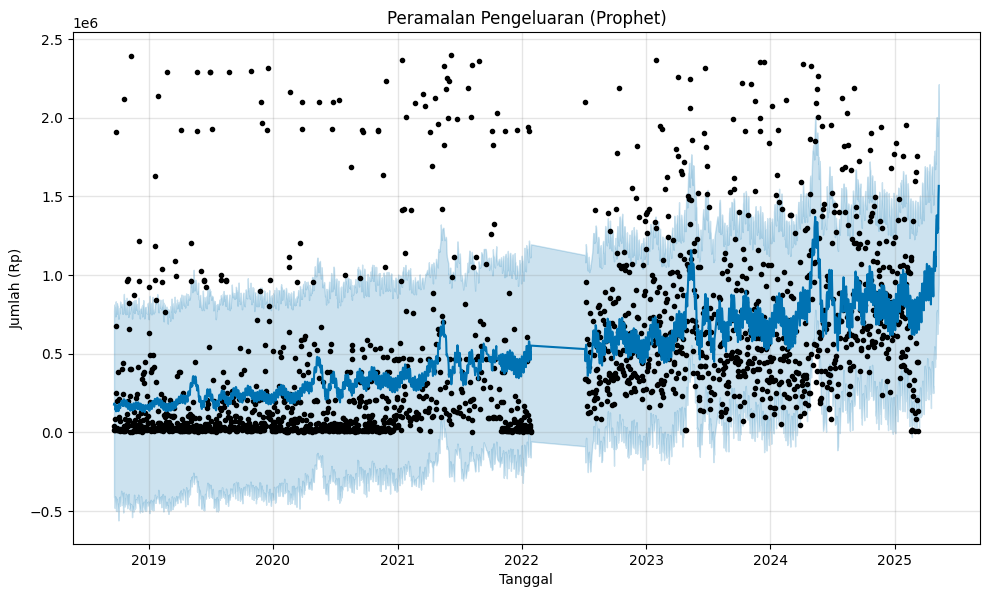

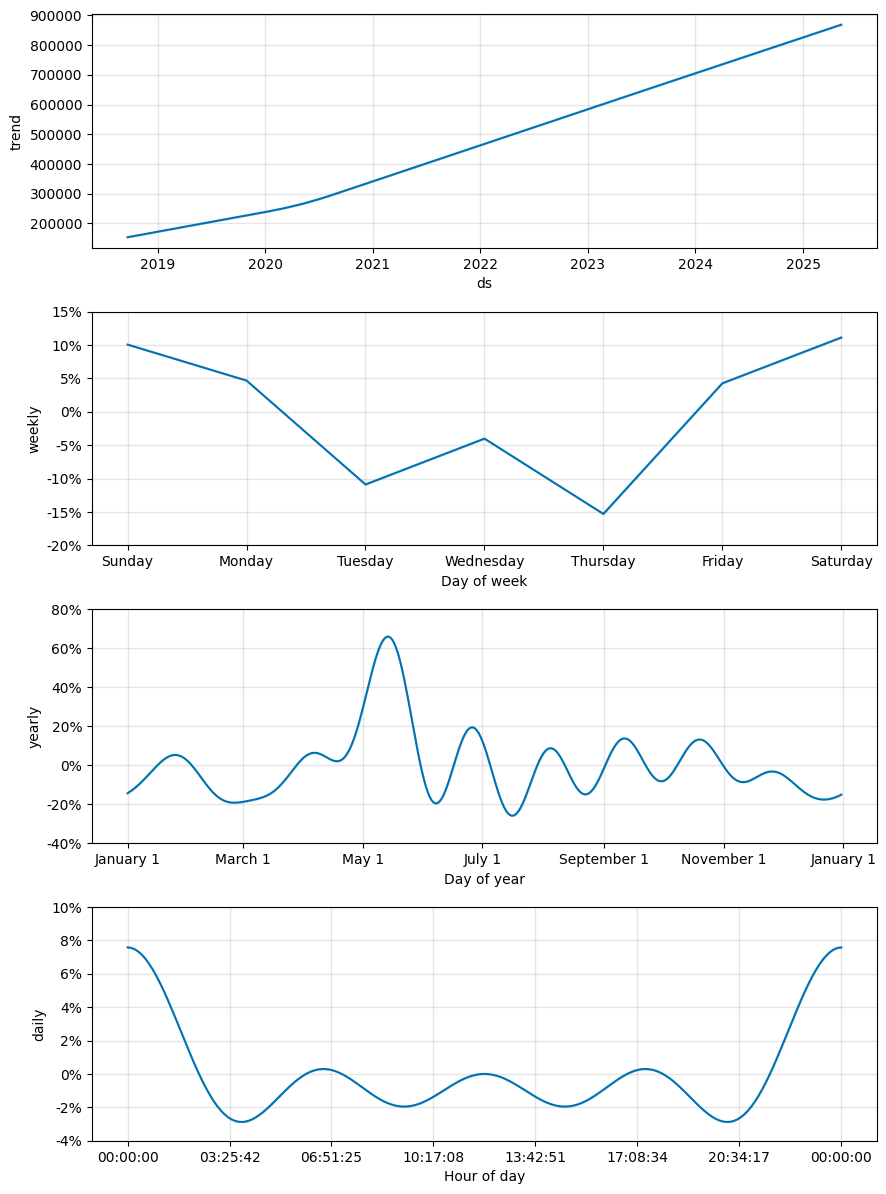

In [163]:
# Ubah nama kolom agar sesuai format Prophet ('ds' = tanggal, 'y' = nilai)
pengeluaran_df = pengeluaran_per_hari.rename(columns={'date': 'ds', 'amount': 'y'})

# Bersihkan outlier menggunakan metode IQR (Interquartile Range)
Q1 = pengeluaran_df['y'].quantile(0.25)
Q3 = pengeluaran_df['y'].quantile(0.75)
IQR = Q3 - Q1
pengeluaran_df_clean = pengeluaran_df[~((pengeluaran_df['y'] < (Q1 - 1.5 * IQR)) | (pengeluaran_df['y'] > (Q3 + 1.5 * IQR)))]

# Inisialisasi dan latih model Prophet
prophet_pengeluaran = Prophet(daily_seasonality=True, seasonality_mode='multiplicative')
prophet_pengeluaran.fit(pengeluaran_df_clean)

# Prediksi pengeluaran untuk 60 hari ke depan
future_pengeluaran = prophet_pengeluaran.make_future_dataframe(periods=60)
forecast_pengeluaran = prophet_pengeluaran.predict(future_pengeluaran)

# Visualisasi hasil prediksi
fig1 = prophet_pengeluaran.plot(forecast_pengeluaran)
plt.title("Peramalan Pengeluaran (Prophet)")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah (Rp)")
plt.grid(True)
plt.show()

# Visualisasi komponen tren dan musiman pengeluaran
prophet_pengeluaran.plot_components(forecast_pengeluaran)
plt.show()

## 📈 Peramalan Pemasukan Harian
Tahap ini dilakukan untuk memproyeksikan pemasukan harian selama 60 hari ke depan. Seperti sebelumnya, dilakukan pembersihan outlier sebelum model Prophet dilatih.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpojkew9re/09x2z7a4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpojkew9re/od_dwe70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53671', 'data', 'file=/tmp/tmpojkew9re/09x2z7a4.json', 'init=/tmp/tmpojkew9re/od_dwe70.json', 'output', 'file=/tmp/tmpojkew9re/prophet_modelwnxmm2f3/prophet_model-20250611081324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:13:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:13:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


111


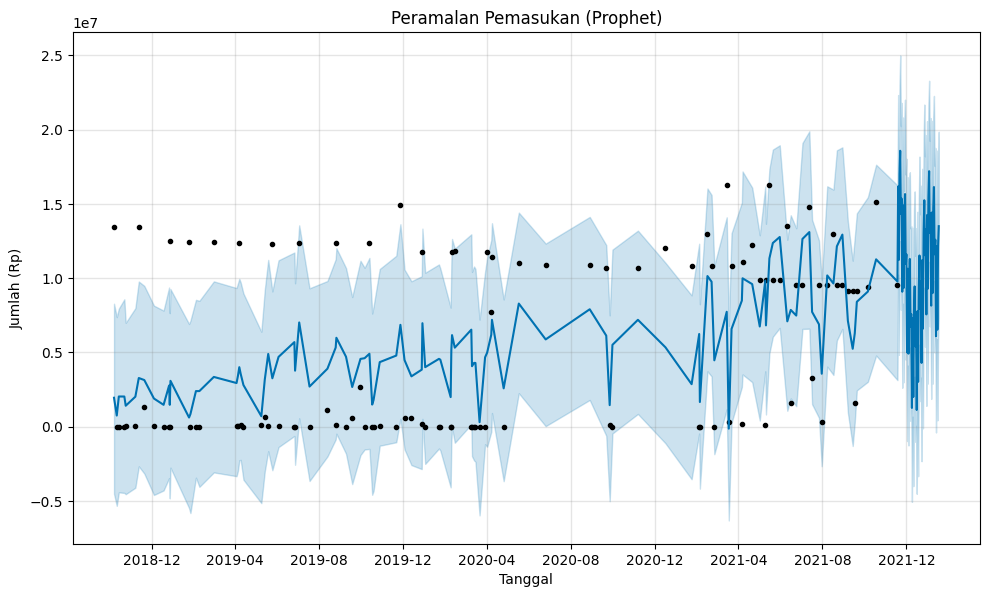

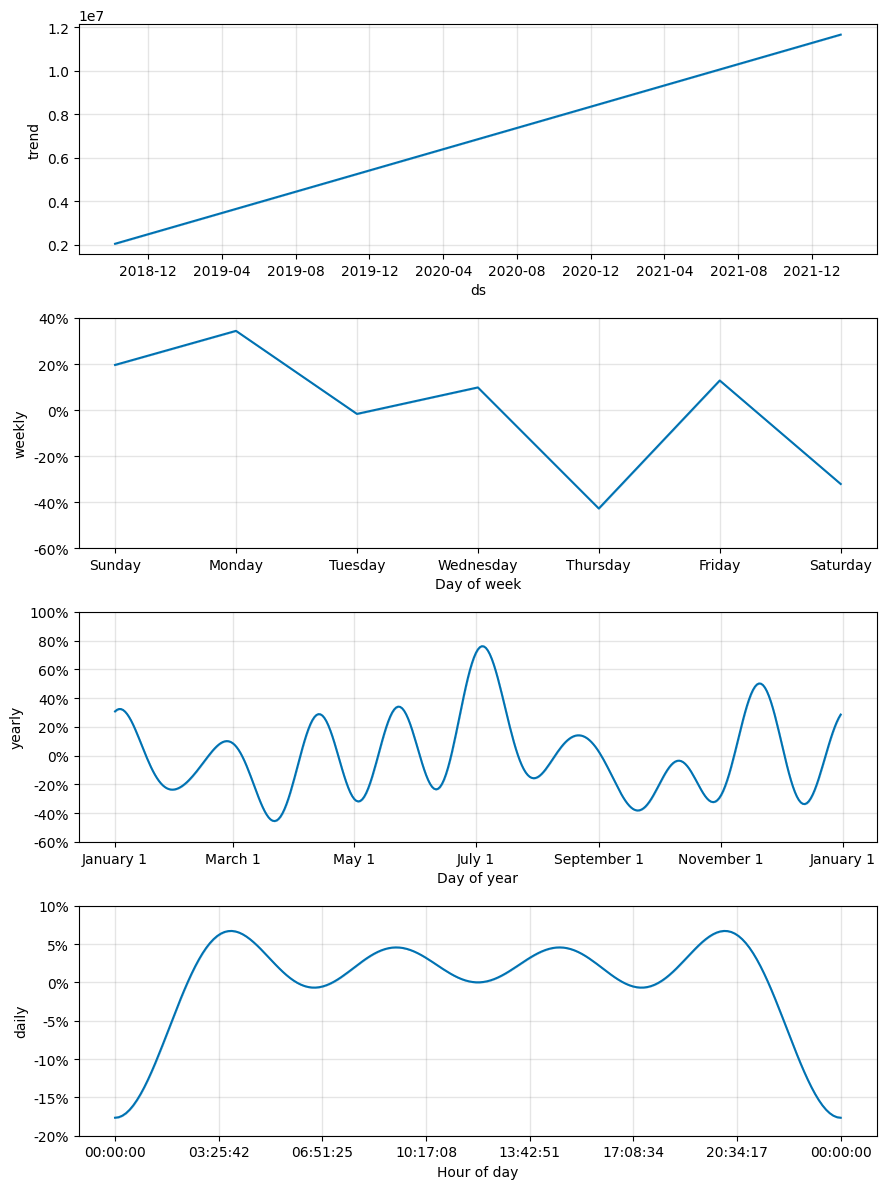

In [164]:
# Sesuaikan nama kolom untuk Prophet
pemasukan_df = pemasukan_per_hari.rename(columns={'date': 'ds', 'amount': 'y'})

# Bersihkan outlier dengan metode IQR
Q1 = pemasukan_df['y'].quantile(0.25)
Q3 = pemasukan_df['y'].quantile(0.75)
IQR = Q3 - Q1
pemasukan_df_clean = pemasukan_df[~((pemasukan_df['y'] < (Q1 - 1.5 * IQR)) | (pemasukan_df['y'] > (Q3 + 1.5 * IQR)))]

print(len(pemasukan_df_clean))

# Inisialisasi dan latih model Prophet
prophet_pemasukan = Prophet(daily_seasonality=True, seasonality_mode='multiplicative')
prophet_pemasukan.fit(pemasukan_df_clean)

# Prediksi pemasukan 60 hari ke depan
future_pemasukan = prophet_pemasukan.make_future_dataframe(periods=60)
forecast_pemasukan = prophet_pemasukan.predict(future_pemasukan)

# Visualisasi hasil prediksi pemasukan
fig2 = prophet_pemasukan.plot(forecast_pemasukan)
plt.title("Peramalan Pemasukan (Prophet)")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah (Rp)")
plt.grid(True)
plt.show()

# Visualisasi komponen tren dan musiman pemasukan
prophet_pemasukan.plot_components(forecast_pemasukan)
plt.show()